In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics  import confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.impute  import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,chi2
import os

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [52]:
df=pd.read_csv('covid.csv')

In [53]:
df

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,9999-99-99,97,2,27,97,...,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,9999-99-99,97,2,24,97,...,2,2,2,2,2,2,2,99,1,97
2,167386,1,2,06-04-2020,01-04-2020,9999-99-99,2,2,54,2,...,2,2,2,2,1,2,2,99,1,2
3,0b5948,2,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,97,...,2,2,2,2,2,2,2,99,1,2
4,0d01b5,1,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,...,2,1,2,1,2,2,2,99,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566597,01ff60,2,1,13-05-2020,03-05-2020,9999-99-99,97,2,58,97,...,2,2,2,2,2,2,2,2,3,97
566598,047cd1,1,1,07-04-2020,06-04-2020,9999-99-99,97,2,48,2,...,2,2,2,2,2,2,2,2,3,97
566599,1beb81,1,2,14-05-2020,01-05-2020,9999-99-99,2,1,49,2,...,2,2,2,2,1,2,2,99,3,2
566600,16fb02,1,1,31-05-2020,29-05-2020,9999-99-99,97,1,43,2,...,2,2,2,2,2,2,2,2,3,97


In [54]:
df.columns

Index(['id', 'sex', 'patient_type', 'entry_date', 'date_symptoms', 'date_died',
       'intubed', 'pneumonia', 'age', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco', 'contact_other_covid',
       'covid_res', 'icu'],
      dtype='object')

In [55]:
df.isna().sum()

id                     0
sex                    0
patient_type           0
entry_date             0
date_symptoms          0
date_died              0
intubed                0
pneumonia              0
age                    0
pregnancy              0
diabetes               0
copd                   0
asthma                 0
inmsupr                0
hypertension           0
other_disease          0
cardiovascular         0
obesity                0
renal_chronic          0
tobacco                0
contact_other_covid    0
covid_res              0
icu                    0
dtype: int64

In [56]:
df['died']=np.where(df['date_died']=="9999-99-99",0,1)

In [57]:
df.loc[:,['died','date_died']].head()

,died,date_died
0,0,9999-99-99
1,0,9999-99-99
2,0,9999-99-99
3,0,9999-99-99
4,1,22-04-2020


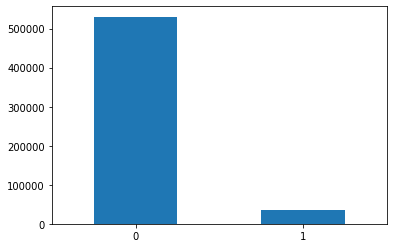

In [58]:
df['died'].value_counts().plot(kind='bar',rot=0)

In [59]:
nan_values=['intubed','pneumonia','pregnancy','diabetes','copd','asthma','inmsupr','hypertension','other_disease','cardiovascular','obesity','renal_chronic','tobacco','contact_other_covid','icu']

In [60]:
for i in nan_values:
    df[i]=np.where(df[i]==97,np.NAN,df[i])
    df[i]=np.where(df[i]==98,np.NAN,df[i])    
    df[i]=np.where(df[i]==99,np.NAN,df[i])    

In [61]:
df.isna().sum().sort_values(ascending=True)

id                          0
covid_res                   0
age                         0
date_died                   0
died                        0
entry_date                  0
sex                         0
patient_type                0
date_symptoms               0
pneumonia                  11
copd                     1749
asthma                   1752
obesity                  1781
renal_chronic            1792
cardiovascular           1822
hypertension             1824
tobacco                  1907
inmsupr                  1980
diabetes                 1981
other_disease            2598
contact_other_covid    175031
pregnancy              288699
intubed                444813
icu                    444814
dtype: int64

In [62]:
for i in nan_values:
    print(f'{i}={df[i].isna().mean()*100}')

intubed=78.5053706128817
pneumonia=0.0019413980183620953
pregnancy=50.95269695482896
diabetes=0.3496281340341192
copd=0.30868228491957317
asthma=0.3092117571063992
inmsupr=0.3494516433051772
hypertension=0.3219190895902238
other_disease=0.4585229137913385
cardiovascular=0.3215661081323398
obesity=0.31432998824571745
renal_chronic=0.3162713862640795
tobacco=0.33656782009241054
contact_other_covid=30.89134877744872
icu=78.50554710361065


# ****Replacing Nan with most frequent values

In [63]:
def impute_nan(frequent,name):
    df[name].fillna(frequent,inplace=True)

In [64]:
for i in ['copd','pneumonia','asthma','obesity','renal_chronic','cardiovascular','hypertension','tobacco','inmsupr','diabetes','other_disease','intubed','pregnancy','icu','contact_other_covid']:
    frequent=df[i].mode()[0]
    impute_nan(frequent,i)

In [65]:
X=df.loc[:,['age','patient_type','pneumonia','intubed','contact_other_covid','covid_res','diabetes','hypertension','sex']]
X.shape
X.head()
y=df['icu']

In [66]:
x_res,y_res=SMOTE().fit_resample(X,y)

In [67]:
X.isna().sum()

age                    0
patient_type           0
pneumonia              0
intubed                0
contact_other_covid    0
covid_res              0
diabetes               0
hypertension           0
sex                    0
dtype: int64

In [68]:
x_res.shape

(1112980, 9)

1.0    556490
2.0    556490
Name: icu, dtype: int64

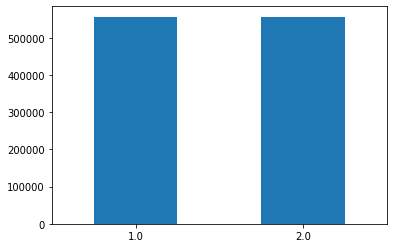

In [84]:
y_res.value_counts().plot(kind='bar',rot=0)
y_res.value_counts()

Text(0, 0.5, 'Count')

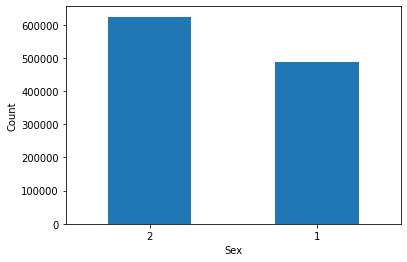

In [71]:
x_res['sex'].value_counts().plot(kind='bar',rot=0)
plt.xlabel('Sex')
plt.ylabel('Count')

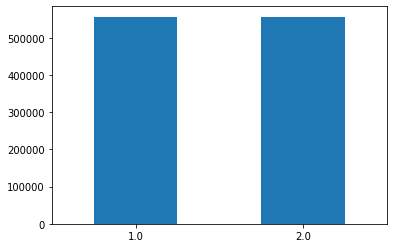

In [72]:
count=pd.value_counts(y_res)
count.plot(kind='bar',rot=0)

In [35]:
print(featureselect.nlargest(9,'score'))

            score             features
4   405798.946612                  age
1   111015.284435         patient_type
3    92524.460176            pneumonia
2    38788.481383              intubed
16   13936.592808  contact_other_covid
17   13775.222237            covid_res
6     4143.516021             diabetes
10    3304.721884         hypertension
0     1701.231219                  sex


(566602, 9)

In [86]:
X_train,X_test,y_train,y_test=train_test_split(x_res,y_res,test_size=0.20,random_state=0)

In [87]:
model1=RandomForestClassifier(n_estimators=5)

In [88]:
model1.fit(X_train,y_train)

RandomForestClassifier(n_estimators=5)

In [89]:
y_pred=model1.predict(X_test)

In [111]:
confusion_matrix(y_test,y_pred)

array([[109095,   2257],
       [  9216, 102028]])

In [112]:
df['icu'].value_counts()

2.0    556490
1.0     10112
Name: icu, dtype: int64

In [113]:
accuracy_score(y_test,y_pred)

0.9484581933188377

In [114]:
import pickle

In [115]:
with open('model.pkl','wb') as f:
    pickle.dump(model1,f)

In [127]:
y_pred1=np.array([[47, 2 ,1.0 ,2.0 ,1.0, 1 ,1.0 ,2.0 ,2]])

In [128]:
pred=model1.predict(y_pred1)

In [129]:
pred

array([1.])

In [126]:
for i in range(len(df['icu'])):
    if df['icu'][i]==1:
        print(df['age'][i],df['patient_type'][i],df['pneumonia'][i],df['intubed'][i],df['contact_other_covid'][i],df['covid_res'][i],df['diabetes'][i],df['hypertension'][i],df['sex'][i])

47 2 1.0 2.0 1.0 1 1.0 2.0 2
66 2 1.0 1.0 1.0 1 2.0 2.0 2
58 2 1.0 2.0 1.0 1 1.0 2.0 2
31 2 1.0 2.0 1.0 1 2.0 2.0 1
58 2 1.0 2.0 1.0 1 2.0 1.0 1
78 2 1.0 2.0 1.0 1 2.0 1.0 1
65 2 1.0 1.0 2.0 1 2.0 2.0 1
66 2 1.0 2.0 1.0 1 1.0 1.0 2
51 2 1.0 1.0 2.0 1 2.0 2.0 2
48 2 1.0 2.0 1.0 1 1.0 2.0 1
52 2 2.0 2.0 1.0 1 1.0 1.0 2
66 2 2.0 2.0 1.0 1 2.0 2.0 2
46 2 2.0 2.0 1.0 1 1.0 1.0 2
52 2 1.0 1.0 1.0 1 2.0 1.0 1
40 2 1.0 2.0 1.0 1 2.0 2.0 1
0 2 2.0 2.0 1.0 1 2.0 2.0 1
38 2 2.0 2.0 1.0 1 2.0 2.0 1
58 2 2.0 2.0 1.0 1 2.0 2.0 2
84 2 1.0 2.0 1.0 1 2.0 1.0 1
0 2 2.0 2.0 1.0 1 2.0 2.0 1
30 2 1.0 2.0 1.0 1 2.0 2.0 2
48 2 1.0 2.0 1.0 1 2.0 2.0 2
31 2 1.0 2.0 2.0 1 2.0 2.0 2
49 2 2.0 2.0 1.0 1 2.0 2.0 2
80 2 2.0 2.0 1.0 1 1.0 1.0 2
42 2 1.0 1.0 2.0 1 2.0 2.0 2
48 2 1.0 2.0 2.0 1 2.0 2.0 2
67 2 2.0 2.0 1.0 1 1.0 1.0 1
48 2 2.0 2.0 1.0 1 2.0 2.0 2
42 2 2.0 2.0 1.0 1 2.0 2.0 1
36 2 1.0 2.0 1.0 1 2.0 2.0 2
49 2 1.0 1.0 2.0 1 2.0 2.0 2
46 2 1.0 2.0 2.0 1 1.0 1.0 2
34 2 1.0 2.0 1.0 1 1.0 2.0 1
59 2 2.0 1.0 1.0

42 2 1.0 1.0 1.0 1 2.0 1.0 1
54 2 1.0 1.0 2.0 1 2.0 1.0 2
56 2 2.0 2.0 1.0 1 2.0 1.0 2
73 2 2.0 2.0 2.0 1 2.0 1.0 1
75 2 2.0 2.0 2.0 1 2.0 1.0 2
46 2 1.0 2.0 2.0 1 2.0 2.0 1
74 2 1.0 1.0 2.0 1 2.0 2.0 2
37 2 1.0 2.0 2.0 1 2.0 2.0 2
52 2 1.0 1.0 2.0 1 1.0 1.0 2
86 2 1.0 1.0 2.0 1 1.0 1.0 1
75 2 1.0 1.0 2.0 1 2.0 1.0 1
41 2 1.0 1.0 2.0 1 2.0 2.0 2
24 2 1.0 1.0 2.0 1 2.0 2.0 1
49 2 1.0 2.0 1.0 1 1.0 2.0 2
54 2 1.0 1.0 1.0 1 1.0 1.0 1
68 2 1.0 2.0 1.0 1 1.0 1.0 2
86 2 1.0 1.0 2.0 1 2.0 2.0 2
26 2 2.0 2.0 1.0 1 1.0 2.0 1
65 2 1.0 1.0 2.0 1 1.0 2.0 1
56 2 1.0 1.0 1.0 1 2.0 1.0 2
88 2 1.0 2.0 2.0 1 1.0 1.0 2
61 2 1.0 1.0 1.0 1 2.0 2.0 2
70 2 1.0 1.0 2.0 1 2.0 2.0 2
62 2 1.0 2.0 2.0 1 1.0 1.0 1
63 2 2.0 2.0 1.0 1 2.0 2.0 2
66 2 1.0 1.0 2.0 1 2.0 1.0 1
36 2 1.0 2.0 1.0 1 2.0 2.0 1
81 2 2.0 2.0 1.0 1 2.0 2.0 1
53 2 1.0 1.0 2.0 1 2.0 2.0 1
40 2 1.0 1.0 1.0 1 2.0 1.0 2
72 2 1.0 2.0 1.0 1 2.0 2.0 2
49 2 1.0 1.0 1.0 1 1.0 1.0 2
0 2 2.0 2.0 1.0 1 2.0 2.0 2
69 2 1.0 1.0 2.0 1 1.0 2.0 2
59 2 1.0 1.0 1.

39 2 1.0 1.0 2.0 1 2.0 2.0 2
64 2 1.0 1.0 1.0 1 2.0 1.0 2
59 2 1.0 1.0 2.0 1 2.0 2.0 1
45 2 1.0 1.0 1.0 1 1.0 1.0 2
62 2 1.0 1.0 1.0 1 2.0 2.0 2
16 2 1.0 2.0 2.0 1 2.0 2.0 2
58 2 1.0 2.0 1.0 1 1.0 1.0 2
47 2 1.0 1.0 2.0 1 2.0 2.0 1
65 2 1.0 1.0 1.0 1 2.0 1.0 1
46 2 1.0 2.0 1.0 1 2.0 2.0 2
42 2 1.0 2.0 2.0 1 2.0 2.0 2
49 2 1.0 1.0 1.0 1 2.0 2.0 1
30 2 1.0 1.0 2.0 1 2.0 2.0 2
62 2 1.0 2.0 2.0 1 1.0 1.0 1
40 2 1.0 1.0 1.0 1 1.0 2.0 2
68 2 2.0 2.0 2.0 1 1.0 1.0 2
56 2 1.0 1.0 1.0 1 2.0 2.0 1
73 2 1.0 1.0 2.0 1 1.0 2.0 2
66 2 1.0 1.0 1.0 1 2.0 1.0 2
52 2 1.0 2.0 2.0 1 2.0 2.0 2
74 2 1.0 1.0 2.0 1 1.0 1.0 2
65 2 1.0 1.0 2.0 1 2.0 1.0 2
84 2 1.0 1.0 2.0 1 1.0 2.0 2
48 2 1.0 2.0 1.0 1 1.0 2.0 2
69 2 1.0 1.0 2.0 1 1.0 2.0 2
63 2 1.0 1.0 2.0 1 2.0 2.0 2
59 2 1.0 2.0 1.0 1 2.0 1.0 2
54 2 1.0 2.0 2.0 1 2.0 2.0 2
28 2 1.0 1.0 2.0 1 2.0 2.0 1
32 2 1.0 2.0 2.0 1 2.0 2.0 1
43 2 1.0 1.0 1.0 1 2.0 2.0 2
38 2 1.0 2.0 1.0 1 2.0 2.0 2
54 2 1.0 2.0 2.0 1 2.0 2.0 2
24 2 1.0 2.0 2.0 1 2.0 2.0 1
52 2 1.0 1.0 2

50 2 1.0 1.0 2.0 1 2.0 2.0 2
71 2 1.0 1.0 1.0 1 1.0 1.0 2
38 2 2.0 2.0 1.0 1 2.0 2.0 2
79 2 1.0 2.0 2.0 1 2.0 2.0 2
61 2 1.0 1.0 2.0 1 1.0 2.0 2
59 2 1.0 1.0 2.0 1 1.0 1.0 1
35 2 1.0 2.0 1.0 1 2.0 2.0 2
66 2 1.0 1.0 1.0 1 2.0 2.0 2
66 2 1.0 1.0 2.0 1 2.0 1.0 2
44 2 1.0 2.0 1.0 1 2.0 2.0 1
82 2 1.0 1.0 2.0 1 1.0 2.0 2
43 2 1.0 1.0 2.0 1 2.0 2.0 2
55 2 1.0 1.0 2.0 1 2.0 2.0 2
48 2 1.0 1.0 2.0 1 1.0 2.0 2
85 2 1.0 1.0 2.0 1 1.0 1.0 2
58 2 1.0 1.0 2.0 1 2.0 2.0 2
60 2 1.0 1.0 2.0 1 2.0 2.0 2
75 2 1.0 1.0 2.0 1 2.0 1.0 2
64 2 1.0 2.0 2.0 1 2.0 2.0 2
70 2 1.0 1.0 1.0 1 2.0 1.0 2
83 2 1.0 2.0 1.0 1 2.0 1.0 1
56 2 1.0 1.0 1.0 1 2.0 2.0 2
48 2 1.0 2.0 2.0 1 2.0 2.0 2
60 2 1.0 2.0 2.0 1 1.0 2.0 1
15 2 2.0 2.0 1.0 1 2.0 2.0 2
30 2 1.0 2.0 2.0 1 2.0 2.0 2
62 2 1.0 1.0 2.0 1 2.0 2.0 2
55 2 1.0 2.0 2.0 1 1.0 2.0 2
56 2 1.0 2.0 1.0 1 2.0 2.0 2
36 2 2.0 1.0 1.0 1 2.0 2.0 1
46 2 1.0 1.0 2.0 1 2.0 2.0 2
70 2 2.0 2.0 1.0 1 2.0 1.0 1
86 2 1.0 1.0 1.0 1 2.0 2.0 2
65 2 1.0 2.0 1.0 1 2.0 1.0 2
89 2 1.0 1.0 2

27 2 1.0 2.0 1.0 1 1.0 2.0 1
52 2 1.0 2.0 1.0 1 2.0 2.0 1
73 2 1.0 1.0 1.0 1 1.0 1.0 2
55 2 1.0 1.0 1.0 1 2.0 2.0 2
58 2 1.0 2.0 1.0 1 2.0 2.0 2
54 2 1.0 1.0 2.0 1 2.0 2.0 2
57 2 1.0 1.0 1.0 1 1.0 2.0 1
48 2 1.0 1.0 2.0 1 1.0 1.0 1
66 2 1.0 1.0 2.0 1 1.0 2.0 1
85 2 1.0 1.0 2.0 1 2.0 1.0 2
30 2 1.0 1.0 1.0 1 2.0 2.0 2
37 2 2.0 2.0 2.0 1 2.0 2.0 2
46 2 1.0 2.0 2.0 1 2.0 2.0 2
57 2 1.0 1.0 2.0 1 2.0 2.0 2
80 2 1.0 1.0 2.0 1 2.0 1.0 2
55 2 1.0 2.0 2.0 1 2.0 1.0 2
62 2 2.0 2.0 2.0 1 1.0 2.0 2
39 2 1.0 1.0 2.0 1 2.0 2.0 1
85 2 1.0 2.0 2.0 1 2.0 2.0 2
75 2 1.0 1.0 1.0 1 2.0 1.0 1
41 2 1.0 1.0 1.0 1 1.0 1.0 2
72 2 1.0 2.0 2.0 1 2.0 2.0 1
38 2 1.0 2.0 2.0 1 2.0 2.0 2
40 2 1.0 1.0 1.0 1 2.0 1.0 1
61 2 1.0 2.0 1.0 1 1.0 1.0 2
66 2 1.0 1.0 1.0 1 2.0 2.0 1
57 2 1.0 2.0 2.0 1 1.0 2.0 2
47 2 1.0 1.0 2.0 1 2.0 2.0 2
32 2 1.0 1.0 2.0 1 2.0 2.0 2
58 2 1.0 1.0 2.0 1 1.0 2.0 2
52 2 1.0 2.0 2.0 1 1.0 2.0 2
1 2 2.0 2.0 2.0 1 2.0 2.0 2
34 2 1.0 1.0 2.0 1 2.0 2.0 2
65 2 1.0 1.0 2.0 1 2.0 2.0 2
61 2 1.0 1.0 2.

50 2 1.0 1.0 2.0 1 2.0 2.0 2
65 2 1.0 1.0 1.0 1 2.0 2.0 2
57 2 1.0 2.0 1.0 1 1.0 1.0 2
39 2 1.0 1.0 2.0 1 2.0 2.0 2
55 2 1.0 2.0 1.0 1 2.0 2.0 2
47 2 1.0 2.0 1.0 1 2.0 2.0 2
70 2 1.0 2.0 1.0 1 2.0 2.0 1
59 2 1.0 1.0 2.0 1 2.0 2.0 1
60 2 1.0 1.0 2.0 1 2.0 2.0 2
52 2 1.0 1.0 2.0 1 2.0 2.0 2
77 2 1.0 1.0 2.0 1 2.0 2.0 2
46 2 1.0 1.0 1.0 1 2.0 2.0 2
55 2 1.0 2.0 1.0 1 2.0 2.0 2
85 2 1.0 2.0 2.0 1 2.0 2.0 2
38 2 1.0 2.0 1.0 1 1.0 2.0 2
65 2 1.0 2.0 2.0 1 2.0 1.0 2
43 2 1.0 1.0 1.0 1 2.0 2.0 1
48 2 1.0 1.0 2.0 1 2.0 2.0 2
86 2 1.0 2.0 2.0 1 2.0 2.0 1
49 2 1.0 2.0 2.0 1 2.0 2.0 2
32 2 1.0 1.0 2.0 1 2.0 2.0 2
59 2 1.0 2.0 1.0 1 2.0 2.0 2
54 2 1.0 1.0 2.0 1 2.0 2.0 2
47 2 1.0 2.0 2.0 1 1.0 2.0 1
65 2 1.0 2.0 2.0 1 2.0 2.0 2
76 2 1.0 2.0 1.0 1 2.0 2.0 2
50 2 1.0 1.0 2.0 1 1.0 1.0 2
72 2 1.0 1.0 2.0 1 2.0 2.0 2
42 2 1.0 1.0 1.0 1 1.0 1.0 2
59 2 1.0 2.0 1.0 1 1.0 2.0 2
60 2 2.0 2.0 1.0 1 2.0 2.0 1
59 2 1.0 1.0 1.0 1 1.0 2.0 2
44 2 1.0 2.0 1.0 1 2.0 2.0 2
67 2 1.0 1.0 2.0 1 1.0 2.0 1
51 2 1.0 1.0 2

49 2 1.0 1.0 1.0 1 2.0 1.0 2
56 2 1.0 1.0 2.0 1 2.0 1.0 1
59 2 1.0 1.0 2.0 1 2.0 2.0 1
60 2 2.0 2.0 2.0 1 2.0 1.0 2
79 2 2.0 2.0 1.0 1 2.0 2.0 2
48 2 1.0 1.0 1.0 1 1.0 2.0 2
63 2 1.0 1.0 1.0 1 1.0 1.0 1
24 2 1.0 1.0 2.0 1 2.0 2.0 2
63 2 1.0 1.0 2.0 1 1.0 1.0 1
68 2 1.0 2.0 2.0 1 1.0 1.0 1
65 2 1.0 1.0 2.0 1 2.0 2.0 2
57 2 1.0 2.0 2.0 1 1.0 1.0 2
73 2 1.0 1.0 2.0 1 1.0 2.0 2
45 2 1.0 1.0 1.0 1 1.0 1.0 2
74 2 1.0 1.0 1.0 1 1.0 2.0 2
76 2 1.0 2.0 1.0 1 2.0 2.0 2
52 2 1.0 2.0 2.0 1 2.0 2.0 2
25 2 1.0 2.0 2.0 1 1.0 2.0 1
69 2 1.0 1.0 1.0 1 2.0 1.0 2
53 2 2.0 2.0 2.0 1 2.0 2.0 1
0 2 1.0 2.0 1.0 1 2.0 2.0 2
45 2 1.0 1.0 2.0 1 2.0 2.0 2
33 2 1.0 2.0 1.0 1 2.0 2.0 2
49 2 1.0 2.0 1.0 1 2.0 2.0 2
80 2 1.0 1.0 1.0 1 2.0 1.0 2
71 2 1.0 1.0 2.0 1 1.0 2.0 2
81 2 1.0 1.0 2.0 1 2.0 2.0 2
0 2 2.0 2.0 1.0 1 2.0 2.0 1
70 2 1.0 2.0 1.0 1 2.0 1.0 1
56 2 1.0 2.0 2.0 1 2.0 2.0 1
65 2 2.0 2.0 2.0 1 1.0 2.0 2
47 2 1.0 1.0 1.0 1 1.0 1.0 2
55 2 1.0 1.0 2.0 1 2.0 2.0 2
46 2 1.0 1.0 2.0 1 1.0 1.0 2
77 2 1.0 2.0 1.0

54 2 1.0 1.0 2.0 1 2.0 1.0 2
35 2 1.0 2.0 2.0 1 2.0 2.0 2
69 2 1.0 2.0 1.0 1 2.0 2.0 2
69 2 1.0 2.0 2.0 1 2.0 2.0 1
66 2 1.0 1.0 2.0 1 1.0 1.0 1
57 2 2.0 2.0 1.0 1 2.0 2.0 1
78 2 1.0 2.0 2.0 1 2.0 1.0 1
65 2 1.0 2.0 2.0 1 1.0 1.0 1
52 2 1.0 2.0 1.0 1 2.0 2.0 2
66 2 1.0 1.0 2.0 1 1.0 1.0 1
63 2 1.0 1.0 2.0 1 2.0 2.0 2
79 2 1.0 1.0 2.0 1 1.0 2.0 2
30 2 1.0 1.0 1.0 1 2.0 2.0 2
68 2 1.0 1.0 1.0 1 2.0 1.0 2
52 2 1.0 2.0 2.0 1 2.0 2.0 1
36 2 1.0 2.0 2.0 1 2.0 2.0 1
55 2 1.0 2.0 2.0 1 2.0 1.0 2
29 2 1.0 1.0 1.0 1 2.0 2.0 2
56 2 1.0 1.0 2.0 1 2.0 2.0 2
60 2 2.0 2.0 2.0 1 2.0 2.0 2
79 2 1.0 2.0 2.0 1 2.0 2.0 2
37 2 2.0 2.0 2.0 1 2.0 2.0 2
43 2 1.0 2.0 2.0 1 2.0 2.0 2
67 2 1.0 1.0 1.0 1 2.0 2.0 2
69 2 1.0 2.0 2.0 1 1.0 1.0 2
51 2 1.0 2.0 2.0 1 2.0 2.0 2
94 2 1.0 2.0 1.0 1 2.0 1.0 2
83 2 1.0 2.0 2.0 1 1.0 1.0 2
61 2 1.0 2.0 1.0 1 1.0 1.0 2
69 2 1.0 2.0 1.0 1 1.0 2.0 2
60 2 1.0 2.0 1.0 1 2.0 1.0 2
81 2 1.0 1.0 1.0 1 2.0 2.0 1
64 2 1.0 1.0 2.0 1 1.0 1.0 2
78 2 1.0 1.0 1.0 1 2.0 1.0 1
92 2 1.0 1.0 2

51 2 2.0 2.0 2.0 1 1.0 1.0 2
63 2 1.0 1.0 1.0 1 2.0 2.0 2
56 2 1.0 1.0 2.0 1 2.0 2.0 2
50 2 1.0 1.0 1.0 1 1.0 1.0 1
61 2 1.0 2.0 1.0 1 2.0 1.0 2
0 2 1.0 2.0 2.0 1 2.0 2.0 2
82 2 1.0 1.0 2.0 1 2.0 1.0 2
34 2 1.0 2.0 2.0 1 2.0 1.0 2
76 2 1.0 1.0 1.0 1 2.0 1.0 2
64 2 1.0 1.0 1.0 1 2.0 2.0 2
51 2 1.0 1.0 2.0 1 2.0 1.0 1
78 2 1.0 1.0 2.0 1 1.0 1.0 1
88 2 1.0 2.0 2.0 1 1.0 2.0 2
37 2 1.0 1.0 1.0 1 2.0 2.0 1
41 2 1.0 1.0 1.0 1 2.0 2.0 2
77 2 1.0 2.0 2.0 1 2.0 2.0 1
74 2 1.0 1.0 2.0 1 1.0 1.0 2
76 2 1.0 1.0 2.0 1 2.0 1.0 2
48 2 2.0 2.0 2.0 1 1.0 2.0 2
47 2 1.0 2.0 1.0 1 2.0 2.0 2
63 2 1.0 1.0 2.0 1 2.0 1.0 2
48 2 1.0 2.0 2.0 1 1.0 2.0 2
70 2 1.0 2.0 1.0 1 2.0 2.0 2
52 2 1.0 2.0 2.0 1 2.0 2.0 2
66 2 1.0 2.0 2.0 1 1.0 1.0 2
44 2 1.0 2.0 2.0 1 2.0 2.0 2
75 2 2.0 2.0 1.0 1 2.0 2.0 2
61 2 1.0 2.0 2.0 1 2.0 2.0 2
77 2 1.0 2.0 2.0 1 2.0 2.0 1
81 2 2.0 2.0 2.0 1 2.0 1.0 1
56 2 2.0 2.0 2.0 1 2.0 2.0 1
45 2 2.0 2.0 1.0 1 2.0 2.0 2
74 2 1.0 1.0 1.0 1 2.0 2.0 1
42 2 1.0 2.0 2.0 1 1.0 2.0 2
36 2 1.0 2.0 1.

81 2 1.0 1.0 2.0 1 2.0 1.0 2
42 2 1.0 1.0 2.0 1 1.0 2.0 2
51 2 1.0 1.0 2.0 1 1.0 1.0 2
53 2 1.0 2.0 1.0 1 2.0 2.0 2
71 2 1.0 1.0 1.0 1 1.0 1.0 2
56 2 1.0 2.0 1.0 1 2.0 2.0 2
65 2 1.0 1.0 2.0 1 2.0 2.0 2
60 2 1.0 1.0 2.0 1 1.0 2.0 2
73 2 1.0 1.0 1.0 1 1.0 1.0 2
70 2 1.0 2.0 1.0 1 2.0 1.0 1
30 2 2.0 2.0 2.0 1 2.0 2.0 2
38 2 1.0 2.0 1.0 1 2.0 2.0 2
10 2 2.0 2.0 1.0 1 2.0 2.0 1
62 2 2.0 1.0 1.0 1 2.0 2.0 2
76 2 2.0 1.0 2.0 1 2.0 1.0 2
45 2 2.0 2.0 2.0 1 2.0 2.0 2
85 2 1.0 1.0 2.0 1 2.0 1.0 1
50 2 1.0 1.0 2.0 1 1.0 2.0 2
51 2 2.0 2.0 1.0 1 2.0 2.0 1
56 2 1.0 2.0 1.0 1 2.0 2.0 2
68 2 1.0 2.0 2.0 1 2.0 2.0 1
34 2 1.0 2.0 1.0 1 2.0 2.0 2
71 2 1.0 2.0 2.0 1 1.0 2.0 1
59 2 1.0 2.0 2.0 1 1.0 1.0 1
78 2 1.0 2.0 2.0 1 1.0 1.0 1
52 2 1.0 2.0 1.0 1 2.0 2.0 2
72 2 1.0 1.0 2.0 1 2.0 2.0 2
73 2 1.0 2.0 2.0 1 1.0 1.0 1
54 2 1.0 1.0 2.0 1 1.0 2.0 2
39 2 1.0 1.0 1.0 1 2.0 2.0 1
93 2 1.0 2.0 2.0 1 2.0 1.0 1
59 2 1.0 2.0 2.0 1 2.0 2.0 2
61 2 1.0 2.0 1.0 1 1.0 1.0 1
52 2 1.0 2.0 2.0 1 2.0 1.0 2
40 2 1.0 1.0 2

65 2 1.0 1.0 2.0 1 2.0 2.0 2
39 2 1.0 2.0 1.0 1 2.0 2.0 2
57 2 1.0 2.0 1.0 1 1.0 1.0 1
32 2 2.0 2.0 1.0 1 1.0 2.0 2
56 2 1.0 1.0 2.0 1 1.0 2.0 2
43 2 2.0 1.0 2.0 1 2.0 2.0 2
45 2 1.0 2.0 1.0 1 1.0 1.0 2
59 2 1.0 1.0 1.0 1 2.0 2.0 1
46 2 1.0 1.0 1.0 1 1.0 1.0 1
42 2 2.0 2.0 1.0 1 2.0 2.0 2
45 2 1.0 1.0 2.0 1 2.0 1.0 2
62 2 1.0 2.0 1.0 1 2.0 2.0 2
73 2 1.0 2.0 2.0 1 2.0 2.0 2
57 2 1.0 1.0 1.0 1 1.0 1.0 1
0 2 1.0 2.0 1.0 1 2.0 2.0 2
44 2 1.0 1.0 2.0 1 2.0 2.0 1
63 2 1.0 1.0 2.0 1 2.0 2.0 2
50 2 1.0 2.0 2.0 1 2.0 2.0 2
57 2 1.0 1.0 2.0 1 2.0 2.0 2
34 2 1.0 1.0 2.0 1 2.0 2.0 2
69 2 1.0 2.0 2.0 1 1.0 1.0 2
31 2 1.0 1.0 2.0 1 2.0 2.0 2
48 2 2.0 2.0 1.0 1 2.0 1.0 2
77 2 1.0 2.0 1.0 1 2.0 1.0 2
54 2 1.0 1.0 2.0 1 2.0 1.0 2
57 2 1.0 1.0 1.0 1 2.0 2.0 1
73 2 2.0 2.0 2.0 1 1.0 1.0 2
60 2 1.0 1.0 1.0 1 1.0 1.0 1
37 2 1.0 2.0 2.0 1 2.0 2.0 1
63 2 1.0 1.0 1.0 1 2.0 2.0 2
63 2 1.0 2.0 2.0 1 2.0 1.0 1
57 2 1.0 1.0 2.0 1 1.0 1.0 1
72 2 1.0 2.0 2.0 1 2.0 1.0 2
64 2 1.0 2.0 2.0 1 2.0 1.0 2
38 2 1.0 1.0 2.

38 2 1.0 2.0 1.0 1 2.0 2.0 1
43 2 1.0 1.0 1.0 1 1.0 1.0 2
37 2 2.0 2.0 2.0 1 2.0 2.0 2
42 2 1.0 1.0 1.0 1 2.0 2.0 2
54 2 1.0 1.0 1.0 1 2.0 2.0 2
62 2 1.0 1.0 2.0 1 2.0 1.0 2
80 2 1.0 1.0 2.0 1 2.0 2.0 2
25 2 2.0 2.0 2.0 1 2.0 2.0 1
60 2 2.0 2.0 2.0 1 2.0 2.0 2
68 2 2.0 2.0 2.0 1 2.0 2.0 2
45 2 2.0 2.0 1.0 1 2.0 2.0 2
44 2 1.0 2.0 1.0 1 1.0 2.0 2
55 2 1.0 2.0 2.0 1 2.0 1.0 1
56 2 1.0 2.0 1.0 1 2.0 1.0 2
59 2 1.0 2.0 2.0 1 2.0 2.0 2
0 2 1.0 1.0 2.0 1 2.0 2.0 2
0 2 1.0 1.0 1.0 1 2.0 2.0 1
55 2 1.0 2.0 1.0 1 2.0 2.0 1
61 2 1.0 2.0 2.0 1 2.0 2.0 2
68 2 1.0 1.0 2.0 1 2.0 2.0 2
64 2 1.0 1.0 2.0 1 2.0 2.0 1
70 2 1.0 2.0 1.0 1 1.0 2.0 2
74 2 1.0 1.0 2.0 1 1.0 1.0 2
40 2 2.0 1.0 1.0 1 2.0 2.0 2
55 2 1.0 1.0 2.0 1 2.0 1.0 1
28 2 2.0 2.0 2.0 1 2.0 2.0 2
44 2 1.0 1.0 1.0 1 2.0 2.0 2
49 2 1.0 1.0 2.0 1 2.0 2.0 2
66 2 1.0 2.0 1.0 1 1.0 1.0 2
23 2 1.0 2.0 2.0 1 2.0 2.0 1
72 2 1.0 1.0 2.0 1 1.0 2.0 2
76 2 1.0 2.0 2.0 1 2.0 2.0 1
0 2 2.0 2.0 1.0 1 2.0 2.0 2
36 2 1.0 2.0 1.0 1 2.0 1.0 1
74 2 1.0 1.0 1.0 

57 2 2.0 2.0 1.0 1 2.0 2.0 2
39 2 1.0 1.0 1.0 1 1.0 2.0 2
37 2 1.0 2.0 2.0 1 2.0 2.0 1
51 2 1.0 1.0 2.0 1 2.0 2.0 2
65 2 1.0 1.0 1.0 1 1.0 1.0 2
26 2 1.0 1.0 2.0 1 1.0 2.0 2
40 2 1.0 1.0 2.0 1 2.0 2.0 2
68 2 1.0 1.0 2.0 1 1.0 2.0 2
79 2 1.0 2.0 1.0 1 2.0 1.0 1
40 2 2.0 2.0 1.0 1 2.0 2.0 1
36 2 1.0 1.0 1.0 1 2.0 2.0 2
37 2 1.0 1.0 2.0 1 2.0 2.0 2
73 2 1.0 2.0 1.0 1 1.0 2.0 2
59 2 1.0 1.0 2.0 1 2.0 1.0 2
49 2 1.0 1.0 1.0 1 2.0 2.0 1
72 2 1.0 2.0 2.0 1 2.0 2.0 1
57 2 1.0 1.0 1.0 1 2.0 1.0 1
59 2 1.0 2.0 1.0 1 2.0 1.0 2
59 2 1.0 1.0 1.0 1 2.0 1.0 2
55 2 2.0 2.0 2.0 1 2.0 2.0 1
49 2 1.0 2.0 2.0 1 2.0 1.0 1
57 2 1.0 1.0 1.0 1 2.0 1.0 1
60 2 1.0 2.0 2.0 1 2.0 2.0 1
54 2 1.0 2.0 2.0 1 2.0 2.0 2
62 2 1.0 2.0 1.0 1 1.0 1.0 1
74 2 1.0 1.0 2.0 1 2.0 1.0 2
63 2 1.0 1.0 2.0 1 2.0 1.0 2
85 2 1.0 1.0 2.0 1 2.0 2.0 2
57 2 1.0 1.0 1.0 1 1.0 2.0 2
53 2 1.0 1.0 2.0 1 2.0 2.0 2
58 2 1.0 1.0 2.0 1 2.0 2.0 1
14 2 1.0 1.0 1.0 1 2.0 2.0 2
65 2 1.0 2.0 1.0 1 1.0 2.0 2
74 2 2.0 2.0 2.0 1 2.0 1.0 1
68 2 1.0 1.0 1

76 2 2.0 1.0 1.0 1 1.0 1.0 1
52 2 1.0 1.0 2.0 1 2.0 1.0 2
73 2 1.0 2.0 1.0 1 2.0 2.0 2
73 2 1.0 1.0 2.0 1 2.0 2.0 1
67 2 1.0 2.0 2.0 1 2.0 2.0 2
49 2 1.0 1.0 2.0 1 1.0 1.0 2
50 2 1.0 1.0 2.0 1 1.0 1.0 2
57 2 2.0 2.0 1.0 1 2.0 2.0 2
62 2 1.0 2.0 1.0 1 1.0 1.0 1
53 2 1.0 1.0 1.0 1 2.0 2.0 1
63 2 1.0 1.0 2.0 1 2.0 2.0 2
40 2 1.0 2.0 1.0 1 2.0 2.0 1
62 2 1.0 1.0 2.0 1 1.0 1.0 1
61 2 1.0 1.0 1.0 1 1.0 2.0 1
56 2 1.0 1.0 1.0 1 1.0 2.0 2
86 2 1.0 2.0 2.0 1 2.0 2.0 2
58 2 1.0 2.0 2.0 1 2.0 1.0 1
40 2 1.0 1.0 1.0 1 2.0 2.0 2
75 2 1.0 1.0 2.0 1 2.0 2.0 2
66 2 2.0 2.0 1.0 1 2.0 2.0 2
45 2 1.0 2.0 2.0 1 1.0 1.0 1
66 2 1.0 2.0 1.0 1 1.0 1.0 2
58 2 1.0 1.0 1.0 1 2.0 2.0 2
20 2 1.0 1.0 2.0 1 2.0 1.0 1
27 2 1.0 2.0 2.0 1 2.0 2.0 2
57 2 1.0 2.0 1.0 1 1.0 2.0 2
48 2 1.0 2.0 1.0 1 2.0 1.0 2
61 2 1.0 1.0 2.0 1 2.0 1.0 2
51 2 2.0 2.0 1.0 1 2.0 2.0 1
58 2 1.0 1.0 2.0 1 2.0 1.0 2
88 2 1.0 1.0 2.0 1 2.0 1.0 1
46 2 1.0 2.0 2.0 1 1.0 1.0 1
55 2 1.0 2.0 2.0 1 1.0 2.0 2
31 2 1.0 2.0 1.0 1 2.0 2.0 2
86 2 1.0 1.0 2

89 2 1.0 2.0 2.0 1 2.0 1.0 2
48 2 1.0 1.0 2.0 1 2.0 2.0 1
42 2 1.0 1.0 2.0 1 2.0 2.0 2
61 2 1.0 1.0 2.0 1 2.0 1.0 2
62 2 1.0 1.0 2.0 1 2.0 2.0 1
71 2 1.0 2.0 2.0 1 2.0 1.0 2
54 2 1.0 1.0 2.0 1 2.0 1.0 2
29 2 1.0 1.0 2.0 1 2.0 2.0 1
80 2 2.0 1.0 1.0 1 2.0 1.0 2
51 2 1.0 1.0 1.0 1 1.0 1.0 2
59 2 1.0 2.0 2.0 1 2.0 1.0 1
77 2 1.0 1.0 1.0 1 2.0 1.0 2
19 2 1.0 2.0 1.0 1 2.0 2.0 1
73 2 2.0 2.0 1.0 1 1.0 1.0 2
34 2 2.0 1.0 2.0 1 2.0 2.0 1
58 2 1.0 1.0 2.0 1 2.0 2.0 2
58 2 1.0 2.0 1.0 1 2.0 2.0 1
60 2 1.0 1.0 1.0 1 1.0 1.0 2
72 2 1.0 1.0 2.0 1 1.0 1.0 1
47 2 2.0 2.0 2.0 1 2.0 2.0 2
49 2 1.0 1.0 2.0 1 2.0 2.0 2
51 2 1.0 1.0 1.0 1 2.0 2.0 2
68 2 2.0 2.0 2.0 1 1.0 2.0 1
69 2 1.0 1.0 1.0 1 2.0 2.0 2
64 2 1.0 2.0 2.0 1 2.0 2.0 1
58 2 2.0 1.0 1.0 1 1.0 1.0 1
75 2 1.0 1.0 1.0 1 1.0 1.0 2
44 2 1.0 1.0 1.0 1 2.0 1.0 2
50 2 1.0 2.0 2.0 1 2.0 2.0 1
41 2 1.0 2.0 1.0 1 1.0 2.0 2
79 2 1.0 1.0 2.0 1 2.0 2.0 1
55 2 1.0 2.0 1.0 1 2.0 2.0 2
27 2 1.0 1.0 2.0 1 2.0 2.0 2
37 2 1.0 1.0 1.0 1 1.0 2.0 2
0 2 1.0 1.0 1.

51 2 1.0 1.0 1.0 1 1.0 1.0 1
51 2 2.0 1.0 1.0 1 2.0 2.0 2
61 2 1.0 2.0 1.0 1 2.0 1.0 2
73 2 1.0 1.0 1.0 1 2.0 2.0 2
41 2 1.0 2.0 1.0 1 2.0 2.0 2
49 2 1.0 1.0 1.0 1 2.0 2.0 1
42 2 1.0 1.0 2.0 1 1.0 2.0 1
57 2 1.0 1.0 2.0 1 2.0 2.0 2
62 2 1.0 2.0 1.0 1 1.0 1.0 1
56 2 2.0 2.0 1.0 1 2.0 1.0 1
73 2 1.0 2.0 2.0 1 2.0 1.0 1
24 2 2.0 2.0 2.0 1 1.0 2.0 2
68 2 1.0 1.0 1.0 1 1.0 1.0 2
40 2 2.0 2.0 1.0 1 2.0 2.0 2
45 2 1.0 1.0 2.0 1 2.0 2.0 1
54 2 1.0 2.0 2.0 1 1.0 1.0 2
84 2 1.0 1.0 2.0 1 2.0 1.0 1
50 2 1.0 1.0 2.0 1 2.0 2.0 2
43 2 1.0 1.0 2.0 1 1.0 2.0 2
57 2 2.0 2.0 2.0 1 2.0 2.0 2
77 2 1.0 1.0 2.0 1 1.0 1.0 2
48 2 1.0 2.0 2.0 1 2.0 2.0 2
60 2 2.0 2.0 2.0 1 1.0 1.0 1
68 2 1.0 1.0 2.0 1 1.0 1.0 1
82 2 1.0 1.0 2.0 1 2.0 2.0 2
80 2 1.0 1.0 2.0 1 1.0 2.0 1
44 2 1.0 1.0 2.0 1 2.0 1.0 1
57 2 1.0 2.0 2.0 1 2.0 2.0 2
63 2 1.0 2.0 1.0 1 2.0 1.0 2
66 2 2.0 1.0 1.0 1 1.0 1.0 2
83 2 1.0 1.0 2.0 1 1.0 1.0 2
74 2 1.0 1.0 2.0 1 2.0 2.0 2
45 2 1.0 2.0 1.0 1 2.0 1.0 2
74 2 1.0 1.0 1.0 1 1.0 2.0 2
61 2 1.0 1.0 2

70 2 1.0 2.0 2.0 1 2.0 1.0 2
52 2 1.0 2.0 1.0 1 1.0 1.0 1
63 2 2.0 1.0 2.0 1 2.0 2.0 2
56 2 1.0 1.0 1.0 1 2.0 2.0 2
57 2 1.0 1.0 1.0 1 2.0 1.0 2
80 2 2.0 2.0 1.0 1 2.0 1.0 1
50 2 1.0 1.0 1.0 1 1.0 2.0 1
71 2 1.0 1.0 1.0 1 2.0 1.0 1
46 2 1.0 1.0 2.0 1 1.0 2.0 2
50 2 1.0 1.0 1.0 1 2.0 2.0 2
55 2 1.0 1.0 2.0 1 1.0 2.0 1
57 2 1.0 1.0 2.0 1 2.0 2.0 2
71 2 1.0 1.0 1.0 1 2.0 2.0 1
31 2 1.0 2.0 1.0 1 2.0 2.0 1
55 2 2.0 2.0 1.0 1 2.0 2.0 2
70 2 1.0 2.0 1.0 1 1.0 1.0 1
66 2 1.0 1.0 1.0 1 2.0 1.0 1
64 2 2.0 2.0 2.0 1 2.0 1.0 2
69 2 1.0 2.0 2.0 1 2.0 2.0 1
77 2 1.0 1.0 2.0 1 1.0 1.0 2
41 2 1.0 1.0 2.0 1 2.0 2.0 2
67 2 1.0 2.0 2.0 1 2.0 1.0 1
75 2 1.0 1.0 2.0 1 1.0 1.0 1
65 2 1.0 2.0 2.0 1 2.0 1.0 1
56 2 1.0 2.0 2.0 1 2.0 2.0 2
66 2 1.0 1.0 2.0 1 1.0 1.0 1
60 2 1.0 2.0 2.0 1 2.0 1.0 2
60 2 1.0 2.0 2.0 1 2.0 2.0 2
30 2 1.0 2.0 1.0 1 1.0 1.0 2
63 2 1.0 1.0 1.0 1 2.0 2.0 1
57 2 1.0 2.0 1.0 1 2.0 1.0 2
65 2 1.0 1.0 2.0 1 2.0 1.0 2
68 2 1.0 1.0 2.0 1 2.0 1.0 2
50 2 1.0 2.0 2.0 1 2.0 1.0 2
34 2 1.0 1.0 2

59 2 1.0 1.0 1.0 2 2.0 2.0 2
59 2 1.0 2.0 1.0 2 2.0 2.0 2
75 2 2.0 2.0 1.0 2 2.0 2.0 2
0 2 2.0 1.0 1.0 2 2.0 2.0 1
74 2 1.0 1.0 1.0 2 1.0 2.0 2
0 2 1.0 1.0 1.0 2 2.0 2.0 1
62 2 1.0 2.0 2.0 2 1.0 1.0 1
62 2 1.0 2.0 2.0 2 1.0 1.0 2
47 2 1.0 2.0 2.0 2 1.0 2.0 2
57 2 1.0 1.0 2.0 2 1.0 1.0 2
35 2 1.0 1.0 2.0 2 2.0 2.0 1
15 2 2.0 2.0 2.0 2 2.0 2.0 1
7 2 1.0 2.0 2.0 2 2.0 2.0 2
1 2 1.0 1.0 1.0 2 2.0 2.0 2
49 2 1.0 2.0 1.0 2 2.0 2.0 1
0 2 1.0 2.0 2.0 2 2.0 2.0 2
54 2 1.0 1.0 1.0 2 1.0 1.0 2
36 2 1.0 2.0 2.0 2 2.0 2.0 1
3 2 1.0 1.0 1.0 2 2.0 2.0 2
31 2 1.0 1.0 1.0 2 2.0 2.0 2
51 2 1.0 1.0 2.0 2 2.0 2.0 2
51 2 1.0 2.0 2.0 2 2.0 2.0 2
44 2 2.0 2.0 2.0 2 2.0 2.0 2
44 2 1.0 1.0 2.0 2 2.0 1.0 2
63 2 1.0 2.0 1.0 2 2.0 2.0 2
66 2 1.0 1.0 2.0 2 2.0 1.0 2
49 2 1.0 2.0 2.0 2 2.0 2.0 1
15 2 2.0 2.0 2.0 2 1.0 2.0 1
2 2 1.0 2.0 2.0 2 2.0 2.0 2
40 2 1.0 2.0 2.0 2 2.0 2.0 1
59 2 1.0 1.0 1.0 2 1.0 2.0 1
75 2 1.0 1.0 1.0 2 2.0 2.0 1
20 2 1.0 1.0 2.0 2 2.0 2.0 2
0 2 1.0 2.0 1.0 2 2.0 2.0 1
29 2 2.0 2.0 2.0 2 1.0

53 2 1.0 1.0 2.0 2 1.0 1.0 2
0 2 1.0 1.0 2.0 2 2.0 2.0 2
0 2 1.0 2.0 2.0 2 2.0 2.0 2
68 2 1.0 1.0 2.0 2 1.0 2.0 2
86 2 1.0 1.0 2.0 2 2.0 2.0 2
77 2 1.0 1.0 2.0 2 2.0 2.0 1
0 2 1.0 2.0 1.0 2 2.0 2.0 1
25 2 1.0 2.0 2.0 2 2.0 2.0 1
86 2 1.0 2.0 2.0 2 2.0 1.0 2
75 2 1.0 2.0 2.0 2 1.0 1.0 1
1 2 1.0 1.0 1.0 2 2.0 2.0 1
1 2 1.0 2.0 2.0 2 2.0 2.0 2
1 2 1.0 1.0 1.0 2 2.0 2.0 2
53 2 2.0 2.0 2.0 2 2.0 2.0 2
49 2 1.0 2.0 1.0 2 2.0 1.0 2
76 2 1.0 2.0 2.0 2 2.0 2.0 1
1 2 1.0 1.0 1.0 2 2.0 2.0 1
39 2 1.0 1.0 2.0 2 2.0 1.0 2
6 2 2.0 2.0 1.0 2 2.0 2.0 1
59 2 2.0 2.0 2.0 2 2.0 2.0 2
51 2 1.0 1.0 2.0 2 1.0 2.0 1
35 2 1.0 2.0 2.0 2 2.0 2.0 2
41 2 2.0 2.0 1.0 2 2.0 2.0 1
44 2 1.0 2.0 2.0 2 1.0 2.0 2
59 2 1.0 1.0 2.0 2 2.0 2.0 1
0 2 2.0 1.0 2.0 2 2.0 2.0 2
2 2 2.0 1.0 2.0 2 2.0 2.0 2
29 2 1.0 2.0 1.0 2 1.0 2.0 1
58 2 1.0 1.0 2.0 2 1.0 2.0 1
77 2 2.0 2.0 2.0 2 2.0 2.0 1
38 2 1.0 2.0 1.0 2 2.0 2.0 1
75 2 1.0 1.0 2.0 2 1.0 1.0 2
71 2 1.0 2.0 2.0 2 2.0 2.0 1
1 2 2.0 2.0 2.0 2 2.0 2.0 1
62 2 1.0 1.0 2.0 2 2.0 2.

68 2 1.0 2.0 2.0 2 1.0 1.0 2
71 2 1.0 2.0 2.0 2 1.0 1.0 1
0 2 2.0 2.0 1.0 2 2.0 2.0 2
35 2 2.0 2.0 1.0 2 1.0 2.0 2
0 2 1.0 2.0 1.0 2 2.0 2.0 2
27 2 1.0 1.0 2.0 2 2.0 2.0 2
9 2 2.0 2.0 2.0 2 2.0 2.0 1
0 2 1.0 2.0 2.0 2 2.0 2.0 1
0 2 1.0 1.0 1.0 2 2.0 2.0 2
8 2 2.0 2.0 2.0 2 2.0 2.0 2
81 2 1.0 2.0 2.0 2 2.0 2.0 2
54 2 1.0 1.0 1.0 2 1.0 2.0 1
42 2 1.0 2.0 2.0 2 2.0 2.0 2
52 2 1.0 1.0 1.0 2 1.0 1.0 2
46 2 1.0 2.0 2.0 2 2.0 2.0 2
59 2 1.0 2.0 2.0 2 2.0 1.0 2
0 2 1.0 1.0 2.0 2 2.0 2.0 1
30 2 2.0 2.0 2.0 2 2.0 2.0 2
15 2 1.0 2.0 2.0 2 2.0 2.0 2
37 2 1.0 1.0 1.0 2 2.0 2.0 2
55 2 1.0 2.0 1.0 2 2.0 2.0 1
55 2 2.0 2.0 1.0 2 1.0 2.0 1
62 2 1.0 2.0 2.0 2 2.0 2.0 2
1 2 2.0 2.0 2.0 2 2.0 2.0 2
73 2 1.0 2.0 1.0 2 1.0 1.0 2
21 2 2.0 2.0 1.0 2 2.0 1.0 1
68 2 1.0 2.0 1.0 2 1.0 1.0 1
21 2 1.0 2.0 2.0 2 2.0 2.0 1
0 2 2.0 1.0 2.0 2 2.0 2.0 1
51 2 1.0 2.0 2.0 2 1.0 1.0 2
12 2 2.0 2.0 2.0 2 2.0 2.0 1
1 2 1.0 2.0 1.0 2 2.0 2.0 1
59 2 1.0 2.0 1.0 2 2.0 2.0 1
54 2 1.0 1.0 1.0 2 2.0 2.0 1
39 2 2.0 2.0 2.0 2 2.0 2

15 2 1.0 2.0 2.0 2 2.0 2.0 1
79 2 1.0 2.0 1.0 2 1.0 2.0 2
46 2 2.0 2.0 1.0 2 2.0 2.0 2
38 2 1.0 1.0 2.0 2 2.0 2.0 2
67 2 1.0 2.0 2.0 2 1.0 2.0 2
30 2 1.0 2.0 1.0 2 2.0 2.0 1
0 2 1.0 1.0 1.0 2 2.0 2.0 2
34 2 2.0 2.0 2.0 2 2.0 2.0 1
65 2 1.0 2.0 2.0 2 1.0 2.0 1
0 2 1.0 2.0 1.0 2 2.0 2.0 2
39 2 2.0 2.0 2.0 2 1.0 2.0 2
51 2 1.0 2.0 1.0 2 1.0 2.0 2
84 2 1.0 1.0 2.0 2 2.0 1.0 2
10 2 1.0 1.0 2.0 2 2.0 2.0 1
71 2 1.0 1.0 1.0 2 1.0 1.0 2
69 2 1.0 2.0 2.0 2 2.0 2.0 1
54 2 2.0 2.0 2.0 2 1.0 2.0 2
1 2 1.0 1.0 2.0 2 2.0 2.0 1
1 2 1.0 1.0 1.0 2 2.0 2.0 2
0 2 2.0 2.0 1.0 2 2.0 2.0 1
72 2 1.0 2.0 2.0 2 1.0 2.0 1
58 2 2.0 1.0 2.0 2 2.0 1.0 1
60 2 1.0 2.0 2.0 2 2.0 2.0 1
66 2 1.0 2.0 1.0 2 2.0 2.0 1
43 2 1.0 1.0 2.0 2 1.0 2.0 2
19 2 1.0 2.0 2.0 2 2.0 2.0 2
66 2 1.0 2.0 2.0 2 2.0 2.0 2
18 2 2.0 2.0 2.0 2 2.0 2.0 2
52 2 1.0 2.0 2.0 2 1.0 1.0 1
12 2 1.0 2.0 1.0 2 2.0 2.0 1
86 2 1.0 1.0 2.0 2 2.0 1.0 1
0 2 1.0 1.0 2.0 2 2.0 2.0 1
66 2 1.0 1.0 2.0 2 1.0 1.0 1
63 2 1.0 1.0 1.0 2 2.0 2.0 2
37 2 1.0 1.0 1.0 2 1

64 2 1.0 2.0 2.0 2 2.0 2.0 2
77 2 1.0 2.0 2.0 2 1.0 1.0 1
1 2 1.0 1.0 2.0 2 2.0 2.0 2
2 2 1.0 1.0 2.0 2 2.0 2.0 1
44 2 2.0 2.0 1.0 2 2.0 1.0 1
15 2 1.0 1.0 2.0 2 2.0 2.0 2
50 2 1.0 2.0 1.0 2 1.0 1.0 2
27 2 1.0 2.0 2.0 2 1.0 2.0 2
53 2 1.0 2.0 1.0 2 2.0 2.0 1
48 2 1.0 1.0 2.0 2 1.0 2.0 2
0 2 1.0 1.0 1.0 2 2.0 2.0 1
48 2 2.0 2.0 1.0 2 2.0 2.0 2
94 2 1.0 1.0 1.0 2 2.0 1.0 2
0 2 2.0 1.0 2.0 2 2.0 2.0 1
0 2 2.0 2.0 1.0 2 2.0 2.0 2
88 2 1.0 2.0 1.0 2 2.0 1.0 2
62 2 1.0 2.0 2.0 2 2.0 2.0 1
68 2 1.0 2.0 2.0 2 2.0 1.0 1
48 2 1.0 2.0 2.0 2 2.0 1.0 1
16 2 1.0 1.0 2.0 2 2.0 2.0 2
50 2 1.0 2.0 1.0 2 2.0 2.0 2
56 2 1.0 1.0 2.0 2 2.0 2.0 2
0 2 1.0 2.0 1.0 2 2.0 2.0 2
42 2 1.0 1.0 2.0 2 2.0 2.0 2
0 2 1.0 1.0 2.0 2 2.0 2.0 2
64 2 2.0 1.0 1.0 2 2.0 2.0 1
32 2 1.0 2.0 1.0 2 2.0 2.0 2
0 2 1.0 1.0 1.0 2 2.0 2.0 2
65 2 1.0 2.0 1.0 2 2.0 1.0 2
82 2 1.0 1.0 1.0 2 2.0 2.0 2
47 2 1.0 1.0 2.0 2 2.0 2.0 2
76 2 2.0 2.0 2.0 2 2.0 2.0 1
40 2 2.0 2.0 2.0 2 2.0 2.0 1
26 2 1.0 1.0 2.0 2 2.0 2.0 2
0 2 2.0 2.0 2.0 2 2.0 

56 2 1.0 1.0 2.0 2 2.0 2.0 2
0 2 2.0 2.0 1.0 2 2.0 2.0 2
0 2 1.0 1.0 2.0 2 2.0 2.0 1
49 2 1.0 1.0 2.0 2 1.0 1.0 2
56 2 1.0 2.0 2.0 2 2.0 2.0 2
74 2 1.0 1.0 1.0 2 2.0 2.0 1
28 2 1.0 2.0 2.0 2 2.0 2.0 2
50 2 1.0 2.0 2.0 2 2.0 2.0 1
66 2 1.0 2.0 2.0 2 2.0 2.0 1
63 2 1.0 1.0 1.0 2 2.0 2.0 2
0 2 1.0 2.0 2.0 2 2.0 2.0 1
48 2 1.0 1.0 2.0 2 1.0 2.0 2
73 2 1.0 2.0 1.0 2 2.0 2.0 1
89 2 2.0 2.0 2.0 2 2.0 1.0 2
17 2 2.0 2.0 2.0 2 2.0 2.0 1
41 2 1.0 1.0 1.0 2 2.0 2.0 1
62 2 1.0 1.0 1.0 2 1.0 1.0 2
1 2 2.0 2.0 2.0 2 2.0 2.0 2
0 2 1.0 1.0 2.0 2 2.0 2.0 2
0 2 1.0 1.0 1.0 2 2.0 2.0 2
44 2 1.0 2.0 1.0 2 1.0 1.0 1
24 2 1.0 1.0 2.0 2 2.0 2.0 2
41 2 1.0 1.0 1.0 2 2.0 2.0 1
51 2 1.0 2.0 2.0 2 1.0 2.0 1
58 2 1.0 2.0 1.0 2 2.0 2.0 2
47 2 1.0 1.0 2.0 2 2.0 2.0 2
69 2 2.0 2.0 1.0 2 1.0 1.0 1
73 2 1.0 2.0 2.0 2 1.0 2.0 2
54 2 1.0 2.0 1.0 2 2.0 2.0 2
1 2 2.0 2.0 1.0 2 2.0 2.0 1
59 2 1.0 2.0 2.0 2 1.0 1.0 1
71 2 1.0 2.0 2.0 2 2.0 2.0 2
2 2 1.0 1.0 2.0 2 2.0 2.0 2
73 2 1.0 2.0 1.0 2 2.0 1.0 1
54 2 1.0 1.0 2.0 2 1.0

28 2 1.0 2.0 2.0 2 2.0 2.0 2
67 2 1.0 2.0 1.0 2 1.0 1.0 1
53 2 1.0 2.0 1.0 2 1.0 1.0 2
70 2 1.0 1.0 1.0 2 1.0 1.0 2
68 2 1.0 2.0 1.0 2 1.0 1.0 2
83 2 1.0 2.0 1.0 2 1.0 1.0 1
46 2 1.0 2.0 1.0 2 2.0 2.0 2
1 2 2.0 2.0 2.0 2 2.0 2.0 2
90 2 1.0 1.0 2.0 2 2.0 2.0 1
26 2 2.0 1.0 2.0 2 2.0 1.0 1
75 2 1.0 1.0 1.0 2 1.0 1.0 1
10 2 1.0 1.0 2.0 2 2.0 2.0 1
61 2 1.0 2.0 2.0 2 2.0 2.0 2
9 2 1.0 2.0 1.0 2 2.0 2.0 2
50 2 2.0 1.0 2.0 2 2.0 1.0 2
72 2 1.0 2.0 2.0 2 2.0 2.0 2
41 2 2.0 2.0 2.0 2 1.0 1.0 2
39 2 2.0 1.0 2.0 2 2.0 2.0 1
0 2 2.0 2.0 1.0 2 2.0 2.0 1
9 2 1.0 1.0 2.0 2 2.0 2.0 2
90 2 1.0 1.0 2.0 2 1.0 1.0 2
1 2 1.0 2.0 1.0 2 2.0 2.0 2
37 2 1.0 1.0 2.0 2 1.0 2.0 1
100 2 1.0 2.0 1.0 2 2.0 1.0 1
63 2 1.0 2.0 1.0 2 2.0 1.0 1
24 2 2.0 1.0 2.0 2 2.0 2.0 1
67 2 1.0 1.0 2.0 2 2.0 2.0 1
1 2 1.0 1.0 2.0 2 2.0 2.0 1
81 2 1.0 2.0 2.0 2 2.0 2.0 2
58 2 1.0 1.0 2.0 2 1.0 2.0 1
15 2 1.0 2.0 2.0 2 2.0 2.0 2
60 2 1.0 2.0 2.0 2 2.0 1.0 1
1 2 2.0 2.0 2.0 2 2.0 2.0 1
53 2 2.0 1.0 2.0 2 2.0 2.0 1
0 2 1.0 1.0 2.0 2 2.

54 2 2.0 2.0 2.0 2 1.0 2.0 1
0 2 1.0 1.0 1.0 2 2.0 2.0 2
38 2 1.0 2.0 2.0 2 2.0 2.0 2
39 2 2.0 1.0 2.0 2 2.0 2.0 2
24 2 1.0 2.0 2.0 2 2.0 2.0 1
20 2 1.0 2.0 2.0 2 2.0 2.0 2
60 2 1.0 1.0 1.0 2 2.0 2.0 2
96 2 1.0 1.0 1.0 2 2.0 2.0 1
65 2 2.0 2.0 1.0 2 1.0 1.0 2
60 2 2.0 2.0 2.0 2 2.0 2.0 2
0 2 1.0 1.0 2.0 2 2.0 2.0 1
0 2 2.0 2.0 1.0 2 2.0 2.0 2
19 2 2.0 2.0 1.0 2 2.0 2.0 1
84 2 1.0 1.0 1.0 2 1.0 1.0 1
1 2 2.0 2.0 1.0 2 2.0 2.0 2
76 2 1.0 1.0 2.0 2 1.0 2.0 2
67 2 1.0 2.0 2.0 2 1.0 2.0 2
29 2 1.0 2.0 1.0 2 2.0 2.0 1
59 2 2.0 2.0 1.0 2 2.0 1.0 2
63 2 1.0 2.0 2.0 2 1.0 2.0 1
22 2 1.0 1.0 1.0 2 2.0 2.0 2
49 2 1.0 2.0 1.0 2 2.0 2.0 2
76 2 1.0 2.0 1.0 2 1.0 2.0 1
38 2 1.0 2.0 1.0 2 2.0 2.0 2
46 2 2.0 1.0 2.0 2 2.0 2.0 2
77 2 1.0 1.0 1.0 2 2.0 1.0 2
66 2 1.0 1.0 2.0 2 1.0 1.0 1
58 2 1.0 2.0 1.0 2 2.0 1.0 2
90 2 1.0 2.0 2.0 2 2.0 2.0 1
51 2 1.0 1.0 1.0 2 1.0 1.0 1
48 2 1.0 2.0 2.0 2 1.0 2.0 2
63 2 1.0 1.0 1.0 2 2.0 2.0 1
67 2 1.0 1.0 2.0 2 2.0 1.0 2
75 2 1.0 1.0 2.0 2 2.0 1.0 2
8 2 1.0 1.0 1.0 2 

79 2 2.0 2.0 1.0 2 1.0 1.0 1
1 2 2.0 2.0 2.0 2 2.0 2.0 2
87 2 2.0 2.0 2.0 2 2.0 1.0 2
61 2 1.0 1.0 2.0 2 2.0 2.0 2
82 2 1.0 2.0 2.0 2 2.0 1.0 2
31 2 1.0 2.0 1.0 2 2.0 2.0 1
0 2 2.0 2.0 1.0 2 2.0 2.0 2
3 2 1.0 2.0 2.0 2 2.0 2.0 1
1 2 2.0 2.0 1.0 2 2.0 2.0 1
70 2 2.0 2.0 2.0 2 1.0 1.0 2
50 2 1.0 2.0 2.0 2 1.0 2.0 2
53 2 1.0 1.0 2.0 2 1.0 1.0 2
66 2 1.0 2.0 2.0 2 2.0 2.0 1
2 2 1.0 2.0 2.0 2 2.0 2.0 2
51 2 1.0 1.0 1.0 2 1.0 1.0 2
12 2 1.0 1.0 2.0 2 2.0 2.0 2
22 2 1.0 2.0 2.0 2 2.0 2.0 1
0 2 2.0 2.0 1.0 2 2.0 2.0 2
61 2 2.0 2.0 1.0 2 1.0 1.0 2
5 2 2.0 2.0 1.0 2 2.0 2.0 2
39 2 1.0 2.0 2.0 2 1.0 2.0 1
45 2 1.0 2.0 1.0 2 1.0 2.0 2
1 2 1.0 1.0 2.0 2 2.0 2.0 1
52 2 1.0 2.0 2.0 2 1.0 2.0 2
71 2 1.0 2.0 2.0 2 2.0 2.0 2
0 2 2.0 2.0 1.0 2 2.0 2.0 2
0 2 1.0 1.0 2.0 2 2.0 2.0 2
43 2 1.0 1.0 2.0 2 2.0 2.0 1
35 2 1.0 1.0 1.0 2 2.0 2.0 1
1 2 1.0 1.0 2.0 2 2.0 2.0 2
23 2 1.0 2.0 2.0 2 2.0 2.0 1
0 2 2.0 2.0 2.0 2 2.0 2.0 1
73 2 1.0 2.0 2.0 2 2.0 2.0 2
49 2 1.0 1.0 2.0 2 2.0 1.0 2
51 2 1.0 2.0 2.0 2 1.0 2.0

62 2 1.0 2.0 2.0 2 1.0 1.0 2
47 2 1.0 1.0 1.0 2 1.0 1.0 2
56 2 1.0 2.0 2.0 2 2.0 2.0 2
46 2 1.0 2.0 1.0 2 2.0 2.0 2
78 2 1.0 2.0 2.0 2 1.0 2.0 2
56 2 1.0 1.0 2.0 2 2.0 2.0 2
8 2 1.0 2.0 2.0 2 2.0 2.0 2
75 2 1.0 1.0 2.0 2 2.0 2.0 2
65 2 1.0 1.0 2.0 2 2.0 2.0 1
27 2 2.0 2.0 1.0 2 1.0 2.0 2
1 2 1.0 2.0 2.0 2 2.0 2.0 1
46 2 2.0 2.0 2.0 3 2.0 2.0 2
0 2 1.0 2.0 1.0 3 2.0 2.0 2
58 2 1.0 1.0 1.0 3 1.0 1.0 1
0 2 2.0 2.0 1.0 3 2.0 2.0 1
73 2 1.0 2.0 1.0 3 1.0 1.0 1
0 2 2.0 1.0 2.0 3 2.0 2.0 2
51 2 1.0 1.0 2.0 3 2.0 2.0 2
77 2 1.0 1.0 2.0 3 1.0 2.0 1
60 2 1.0 1.0 1.0 3 1.0 2.0 2
54 2 1.0 1.0 2.0 3 2.0 2.0 2
64 2 1.0 2.0 1.0 3 2.0 1.0 2
67 2 1.0 1.0 1.0 3 1.0 1.0 2
54 2 1.0 1.0 2.0 3 2.0 1.0 2
64 2 2.0 2.0 1.0 3 2.0 2.0 1
46 2 2.0 2.0 2.0 3 2.0 2.0 2
61 2 1.0 1.0 1.0 3 1.0 2.0 1
0 2 1.0 2.0 1.0 3 2.0 2.0 1
73 2 1.0 1.0 2.0 3 2.0 2.0 2
73 2 1.0 1.0 1.0 3 2.0 1.0 1
10 2 2.0 2.0 1.0 3 2.0 2.0 2
49 2 1.0 2.0 2.0 3 2.0 1.0 2
50 2 1.0 1.0 2.0 3 2.0 2.0 2
65 2 2.0 1.0 2.0 3 1.0 1.0 2
62 2 1.0 1.0 1.0 3 1

69 2 1.0 1.0 2.0 3 2.0 2.0 2
2 2 2.0 2.0 1.0 3 2.0 2.0 2
60 2 1.0 1.0 1.0 3 1.0 1.0 1
57 2 2.0 2.0 2.0 3 2.0 1.0 1
74 2 1.0 1.0 2.0 3 2.0 1.0 2
21 2 1.0 1.0 1.0 3 2.0 2.0 2
75 2 1.0 1.0 2.0 3 2.0 1.0 2
22 2 2.0 2.0 1.0 3 2.0 2.0 1
65 2 2.0 2.0 1.0 3 2.0 2.0 1
70 2 2.0 2.0 1.0 3 1.0 1.0 2
47 2 1.0 2.0 2.0 3 1.0 2.0 1
61 2 1.0 2.0 2.0 3 1.0 1.0 1
30 2 1.0 1.0 1.0 3 2.0 2.0 1
45 2 1.0 1.0 1.0 3 2.0 2.0 1
1 2 1.0 1.0 1.0 3 2.0 2.0 2
61 2 2.0 2.0 1.0 3 2.0 1.0 1
72 2 1.0 2.0 2.0 3 1.0 1.0 2
0 2 2.0 2.0 1.0 3 2.0 2.0 1
78 2 1.0 2.0 2.0 3 2.0 1.0 1
37 2 1.0 1.0 2.0 3 2.0 2.0 2
51 2 2.0 2.0 2.0 3 1.0 2.0 2
77 2 2.0 2.0 2.0 3 2.0 2.0 1
63 2 2.0 2.0 2.0 3 1.0 2.0 2
36 2 1.0 2.0 2.0 3 2.0 2.0 1
47 2 1.0 1.0 2.0 3 1.0 1.0 2
69 2 1.0 2.0 2.0 3 2.0 2.0 2
83 2 1.0 2.0 2.0 3 1.0 1.0 1
44 2 1.0 2.0 1.0 3 2.0 2.0 2
67 2 1.0 2.0 2.0 3 1.0 1.0 2
75 2 1.0 2.0 2.0 3 1.0 1.0 2
50 2 1.0 1.0 1.0 3 2.0 2.0 2
44 2 1.0 2.0 1.0 3 1.0 1.0 2
62 2 2.0 2.0 1.0 3 2.0 2.0 1
0 2 2.0 1.0 1.0 3 2.0 2.0 2
70 2 1.0 1.0 1.0 3

41 2 1.0 2.0 2.0 3 2.0 2.0 2
42 2 1.0 1.0 2.0 3 2.0 2.0 1
73 2 1.0 1.0 2.0 3 1.0 1.0 1
62 2 1.0 1.0 1.0 3 1.0 2.0 2
32 2 1.0 1.0 1.0 3 2.0 2.0 2
83 2 1.0 2.0 1.0 3 1.0 1.0 1
60 2 2.0 2.0 1.0 3 2.0 1.0 1
69 2 2.0 2.0 1.0 3 1.0 1.0 1
80 2 1.0 2.0 2.0 3 1.0 1.0 1
0 2 1.0 1.0 2.0 3 2.0 2.0 2
54 2 1.0 2.0 1.0 3 2.0 2.0 2
54 2 1.0 2.0 2.0 3 2.0 2.0 2
75 2 1.0 1.0 2.0 3 1.0 1.0 1
73 2 1.0 1.0 2.0 3 2.0 1.0 2
54 2 1.0 2.0 2.0 3 2.0 1.0 2
20 2 1.0 1.0 2.0 3 2.0 2.0 1
0 2 1.0 1.0 2.0 3 2.0 2.0 1
33 2 2.0 2.0 1.0 3 2.0 2.0 1
79 2 1.0 2.0 1.0 3 2.0 1.0 2
88 2 2.0 2.0 1.0 3 2.0 1.0 2
42 2 1.0 1.0 1.0 3 2.0 1.0 2
1 2 2.0 2.0 1.0 3 2.0 2.0 1
77 2 1.0 1.0 2.0 3 1.0 2.0 1
75 2 1.0 2.0 2.0 3 2.0 1.0 2
26 2 1.0 1.0 1.0 3 2.0 2.0 2
35 2 1.0 2.0 1.0 3 1.0 2.0 2
68 2 1.0 2.0 1.0 3 1.0 1.0 1
60 2 1.0 1.0 2.0 3 2.0 2.0 1
50 2 1.0 2.0 2.0 3 2.0 2.0 2
63 2 1.0 2.0 1.0 3 2.0 1.0 2
74 2 1.0 2.0 2.0 3 2.0 2.0 1
36 2 1.0 2.0 1.0 3 2.0 2.0 1
68 2 1.0 1.0 2.0 3 2.0 1.0 1
77 2 1.0 1.0 1.0 3 1.0 1.0 1
57 2 1.0 2.0 2.0 

46 2 2.0 2.0 1.0 3 2.0 1.0 2
31 2 1.0 2.0 1.0 3 2.0 2.0 2
66 2 1.0 2.0 1.0 3 2.0 1.0 2
69 2 1.0 1.0 2.0 3 2.0 2.0 2
86 2 1.0 1.0 2.0 3 2.0 1.0 1
0 2 1.0 1.0 2.0 3 2.0 2.0 1
27 2 1.0 2.0 1.0 3 2.0 2.0 1
52 2 1.0 2.0 2.0 3 2.0 1.0 2
67 2 1.0 2.0 1.0 3 2.0 2.0 2
59 2 1.0 1.0 1.0 3 1.0 1.0 2
76 2 1.0 2.0 2.0 3 2.0 1.0 1
0 2 2.0 2.0 2.0 3 2.0 2.0 2
66 2 1.0 1.0 2.0 3 1.0 2.0 1
76 2 2.0 2.0 2.0 3 1.0 2.0 1
52 2 2.0 2.0 2.0 3 2.0 2.0 2
0 2 1.0 2.0 1.0 3 2.0 2.0 2
77 2 1.0 1.0 2.0 3 1.0 2.0 1
37 2 1.0 2.0 1.0 3 2.0 2.0 2
45 2 1.0 2.0 1.0 3 2.0 2.0 2
71 2 1.0 1.0 2.0 3 2.0 2.0 1
47 2 1.0 1.0 2.0 3 2.0 1.0 1
56 2 1.0 1.0 1.0 3 2.0 2.0 2
40 2 1.0 1.0 2.0 3 2.0 2.0 2
57 2 1.0 2.0 2.0 3 2.0 2.0 2
56 2 1.0 2.0 2.0 3 2.0 2.0 2
52 2 2.0 2.0 1.0 3 1.0 1.0 1
63 2 1.0 2.0 2.0 3 2.0 2.0 1
51 2 2.0 2.0 1.0 3 1.0 2.0 2
66 2 1.0 2.0 2.0 3 2.0 2.0 2
60 2 1.0 1.0 1.0 3 2.0 2.0 2
3 2 2.0 2.0 2.0 3 2.0 2.0 2
36 2 1.0 1.0 1.0 3 2.0 2.0 2
71 2 1.0 2.0 2.0 3 2.0 1.0 2
51 2 1.0 2.0 2.0 3 1.0 2.0 2
80 2 1.0 1.0 2.0 3